<a href="https://colab.research.google.com/github/Theresa-1-2/Theresa-1-2/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Load the dataset
from google.colab import files
uploaded = files.upload()

# Read the dataset
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)
df.head()



Saving bestsellers-with-categories.xlsx to bestsellers-with-categories.xlsx


,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64
       User Rating       Reviews       Price         Year
count   550.000000    550.000000  550.000000   550.000000
mean      4.618364  11953.281818   13.100000  2014.000000
std       0.226980  11731.132017   10.842262     3.165156
min       3.300000     37.000000    0.000000  2009.000000
25%       4.500000   4058.000000    7.000000  2011.000000
50%       4.700000   8580.000000   11.000000  2014.000000
75%       4.800000  17253.250000   16.000000  2017.000000
max       4.900000  87841.000000  105.000000  2019.000000


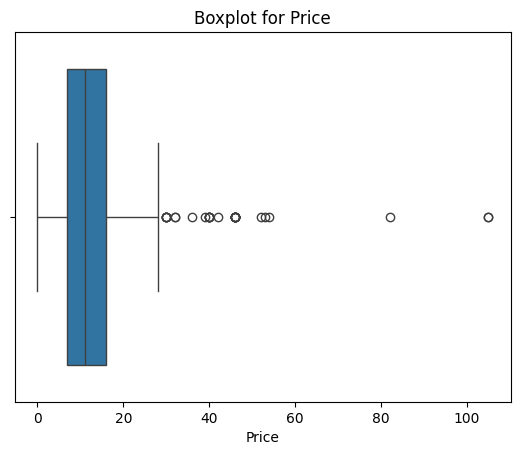

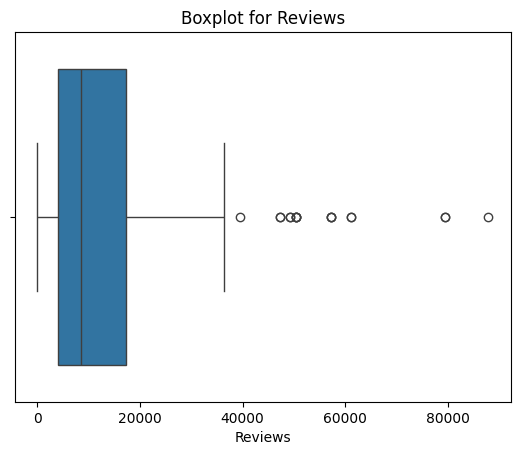

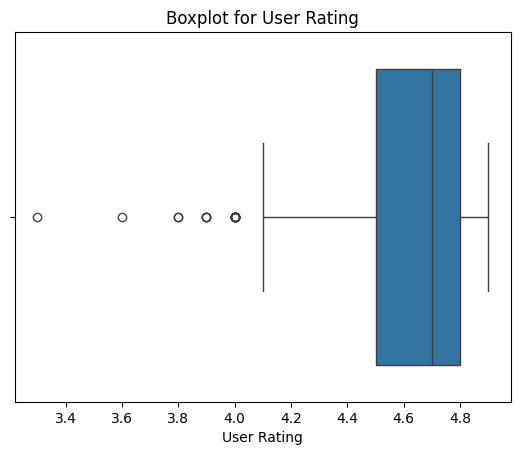

In [6]:
# Check for missing values
print(df.isnull().sum())

# Remove duplicates if any
df.drop_duplicates(inplace=True)

# Summary statistics
print(df.describe())

# Boxplot to check for outliers in numerical columns
numerical_cols = ['Price', 'Reviews', 'User Rating']
for col in numerical_cols:
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot for {col}')
    plt.show()


In [7]:
# Function to remove outliers
def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

for col in numerical_cols:
    df = remove_outliers(df, col)

print(df.shape)


(486, 7)


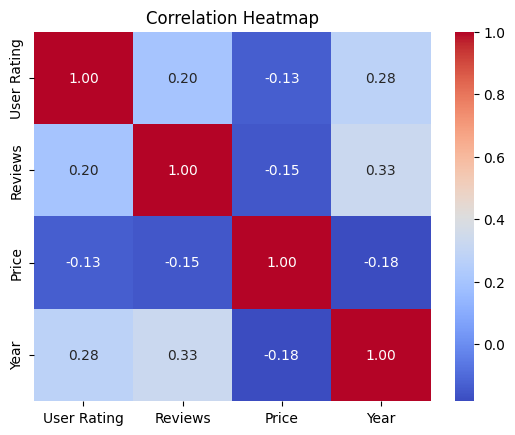

In [8]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Check if there are numeric columns to calculate correlation
if not numeric_df.empty:
    # Correlation heatmap
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print("No numeric columns found for correlation analysis.")


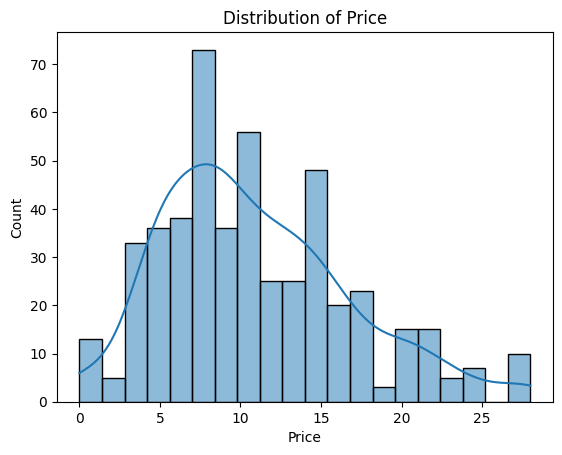

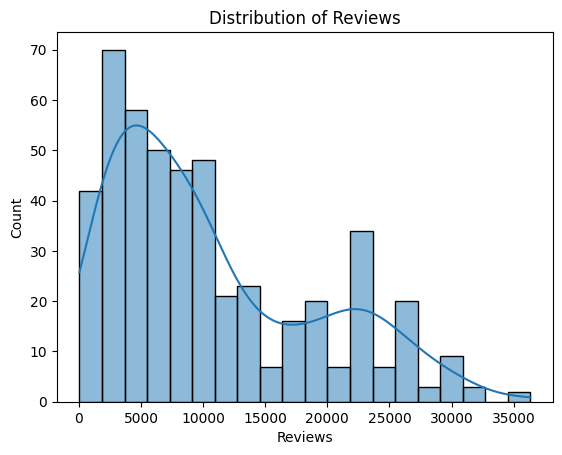

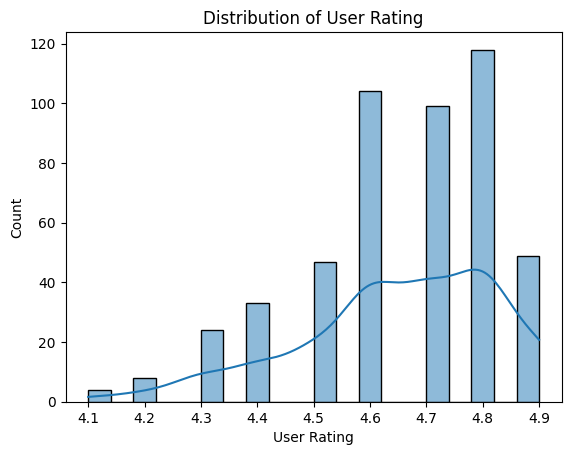

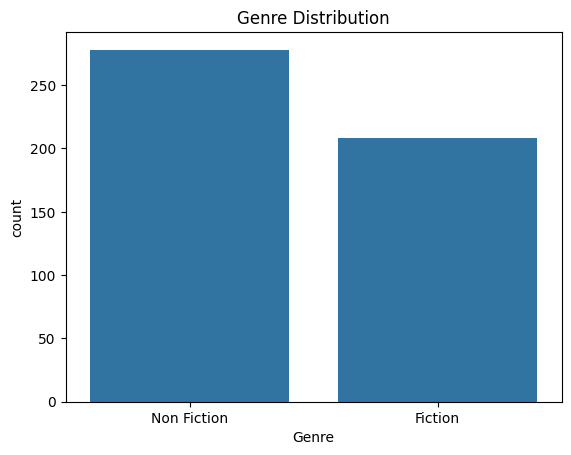

In [9]:
# Distribution plots
for col in numerical_cols:
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

# Genre distribution
sns.countplot(data=df, x='Genre')
plt.title('Genre Distribution')
plt.show()


In [10]:
# Encode Genre column
df['Genre_Encoded'] = df['Genre'].apply(lambda x: 1 if x == 'Non Fiction' else 0)

# Create new features
df['Log_Reviews'] = np.log1p(df['Reviews'])  # Log-transform reviews
df['Rating_Price_Ratio'] = df['User Rating'] / df['Price']
df.head()


,Name,Author,User Rating,Reviews,Price,Year,Genre,Genre_Encoded,Log_Reviews,Rating_Price_Ratio
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction,1,9.761405,0.587500
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction,0,7.627057,0.209091
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction,1,9.851141,0.313333
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction,0,9.972314,0.783333
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction,1,8.944550,0.400000


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

# Choose target and features
target = 'Price'  # Change to 'Genre_Encoded' for classification
features = ['User Rating', 'Reviews', 'Year', 'Genre_Encoded']

X = df[features]
y = df[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train regression models
model = RandomForestRegressor()  # Change to LogisticRegression for classification
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')


MSE: 26.47873283107154


In [12]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
best_model = grid_search.best_estimator_


Best Parameters: {'max_depth': 10, 'n_estimators': 150}


In [13]:
import pickle

# Save model
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Load model
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


In [14]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [15]:
%%writefile app.py

Writing app.py


In [17]:
! wget -q -O - ipv4.icanhazip.com

34.32.244.199


In [20]:
!pip install pyngrok


In [21]:
%%writefile app.py
import streamlit as st

st.title("Book Sales Analysis")
st.write("This application allows you to explore book sales data.")


Overwriting app.py


In [ ]:
from pyngrok import ngrok

# Start the Streamlit app
!streamlit run app.py &







  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.32.244.199:8501

